In [1]:
import os
import sys
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from dnc.dnc import DNC
from feedforward_controller import FeedforwardController

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 18)

In [2]:
def generate_data(batch_size, length, size):

    input_data = np.zeros((batch_size, 2 * length + 1, size), dtype=np.float32)
    target_output = np.zeros((batch_size, 2 * length + 1, size), dtype=np.float32)

    sequence = np.random.binomial(1, 0.5, (batch_size, length, size - 1))

    input_data[:, :length, :size - 1] = sequence
    input_data[:, length, -1] = 1  # the end symbol
    target_output[:, length + 1:, :size - 1] = sequence
    
    return input_data, target_output

In [3]:
def binary_cross_entropy(predictions, targets):

    return tf.reduce_mean(
        -1 * targets * tf.log(predictions) - (1 - targets) * tf.log(1 - predictions)
    )

In [4]:
ckpts_dir = os.path.join(os.path.dirname("__file__"), 'checkpoints')
session = tf.InteractiveSession()

ncomputer = DNC(
    FeedforwardController,
    input_size=6,
    output_size=6,
    max_sequence_length=2*5+1,
    memory_words_num=20,
    memory_word_size=10,
    memory_read_heads=1,
    batch_size=1
)

ncomputer.restore(session, ckpts_dir, 'model-meduim')

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_minimum(a, axis, None, out, keepdims)


In [5]:
outputs, memory_views = ncomputer.get_outputs()
squashed_output = tf.sigmoid(outputs)
clipped_output = tf.clip_by_value(squashed_output, 1e-6, 1. - 1e-6)

loss = binary_cross_entropy(clipped_output, ncomputer.target_output)

In [16]:
input_sequences = []
output_sequences = []
in_memory_views = []
losses = []

for k in range(4):
    input_data, target_output = generate_data(1, 5, 6)
    
    loss_val, dnc_output, memview = session.run([
        loss,
        squashed_output,
        memory_views
    ], feed_dict={
        ncomputer.input_data: input_data,
        ncomputer.target_output: target_output,
        ncomputer.sequence_length: 2*5 + 1
    })
    
    input_sequences.append(np.squeeze(input_data))
    output_sequences.append(np.squeeze(dnc_output))
    in_memory_views.append(memview)
    losses.append(loss_val)

In [17]:
print "Avg. Loss: %.6f" % (np.mean(losses))

Avg. Loss: 0.000001


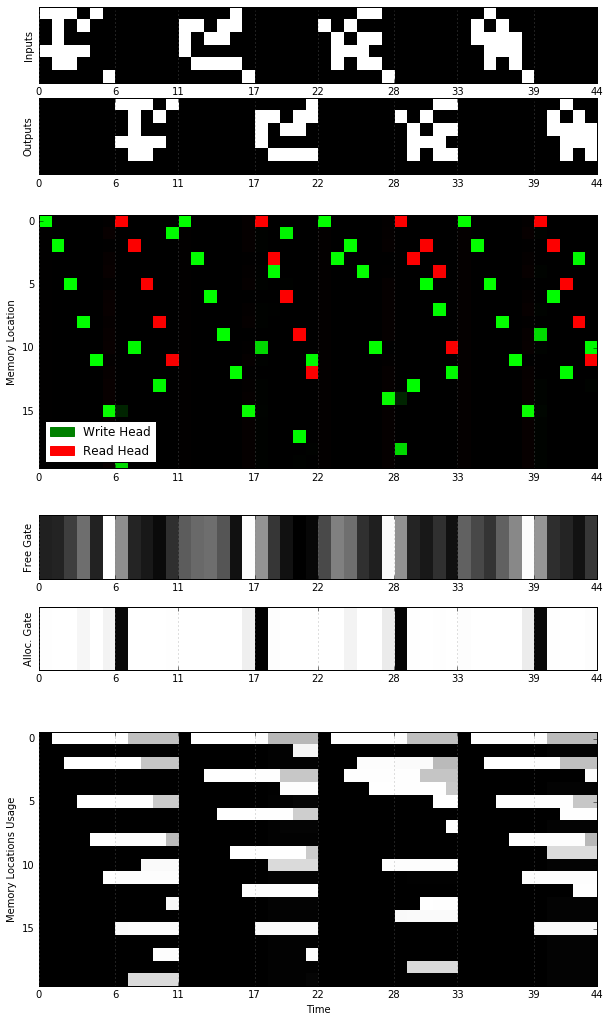

In [18]:
all_the_free_gates = []
all_the_allocation_gates=[]
all_wws = []
all_rws = []
all_usages=[]

for mem_view in in_memory_views:
    all_the_free_gates.append(np.squeeze(mem_view['free_gates']))
    all_the_allocation_gates.append(np.squeeze(mem_view['allocation_gates']))
    all_wws.append(np.squeeze(mem_view['write_weightings']))
    all_rws.append(np.squeeze(mem_view['read_weightings']))
    all_usages.append(np.squeeze(mem_view['usage_vectors']))

input_strip = np.concatenate(input_sequences)
output_strip = np.concatenate(output_sequences)
free_gates_strip = np.concatenate(all_the_free_gates)[:, np.newaxis]
allocation_gates_strip = np.concatenate(all_the_allocation_gates)[:, np.newaxis]
ww_strip = np.concatenate(all_wws)
rw_strip = np.concatenate(all_rws)
usage_strip = np.concatenate(all_usages)

colored_write = np.zeros((ww_strip.shape[0], ww_strip.shape[1], 3))
colored_read = np.zeros((rw_strip.shape[0], rw_strip.shape[1], 3))
for i in range(ww_strip.shape[0]):
    for j in range(ww_strip.shape[1]):
        colored_read[i, j] = [rw_strip[i,j], 0., 0.]
        colored_write[i, j] = [0., ww_strip[i,j], 0.]


gs = gridspec.GridSpec(66, 1, hspace=0)

input_strip_ax = plt.subplot(gs[0:5, 0])
output_strip_ax = plt.subplot(gs[6:11, 0])
rw_strip_ax = plt.subplot(gs[12:32, 0])
free_strip_ax = plt.subplot(gs[33:38, 0])
allocation_strip_ax = plt.subplot(gs[39:44, 0])
usage_strip_ax = plt.subplot(gs[46:, 0])

input_strip_ax.grid(True, color='gray')
output_strip_ax.grid(True, color='gray')
rw_strip_ax.grid(True, color='gray', axis='x')
free_strip_ax.grid(True, color='gray')
allocation_strip_ax.grid(True, color='gray')
usage_strip_ax.grid(True, color='gray', axis='x')


input_strip_ax.imshow(input_strip.T, cmap=plt.cm.gray, interpolation='nearest')
input_strip_ax.set_ylabel("Inputs")
input_strip_ax.set_yticks([])
input_strip_ax.set_xticks([-0.5, 5.5, 10.5, 16.5, 21.5, 27.5, 32.5, 38.5, 43.5])
input_strip_ax.set_xticklabels([0, 6, 11, 17, 22, 28, 33, 39, 44])

output_strip_ax.imshow(output_strip.T, cmap=plt.cm.gray, interpolation='nearest')
output_strip_ax.set_ylabel("Outputs")
output_strip_ax.set_yticks([])
output_strip_ax.set_xticks([-0.5, 5.5, 10.5, 16.5, 21.5, 27.5, 32.5, 38.5, 43.5])
output_strip_ax.set_xticklabels([0, 6, 11, 17, 22, 28, 33, 39, 44])

rw_strip_ax.imshow(np.transpose(colored_write + colored_read, [1, 0, 2]), interpolation='nearest')
rw_strip_ax.set_ylabel("Memory Location")
rw_strip_ax.set_xticks([-0.5, 5.5, 10.5, 16.5, 21.5, 27.5, 32.5, 38.5, 43.5])
rw_strip_ax.set_xticklabels([0, 6, 11, 17, 22, 28, 33, 39, 44])
write_legend = mpatches.Rectangle((1,1), 1, 1, color='green', label='Write Head')
read_legend = mpatches.Rectangle((1,1), 1, 1, color='red', label='Read Head')
rw_strip_ax.legend(loc='lower left', handles=[write_legend, read_legend])

free_strip_ax.imshow(np.hstack([free_gates_strip] * 5).T, cmap=plt.cm.gray, interpolation='nearest')
free_strip_ax.set_ylabel("Free Gate")
free_strip_ax.set_yticks([])
free_strip_ax.set_xticks([-0.5, 5.5, 10.5, 16.5, 21.5, 27.5, 32.5, 38.5, 43.5])
free_strip_ax.set_xticklabels([0, 6, 11, 17, 22, 28, 33, 39, 44])

allocation_strip_ax.imshow(np.hstack([allocation_gates_strip] * 5).T, cmap=plt.cm.gray, interpolation='nearest')
allocation_strip_ax.set_ylabel("Alloc. Gate")
allocation_strip_ax.set_yticks([])
allocation_strip_ax.set_xticks([-0.5, 5.5, 10.5, 16.5, 21.5, 27.5, 32.5, 38.5, 43.5])
allocation_strip_ax.set_xticklabels([0, 6, 11, 17, 22, 28, 33, 39, 44])

usage_strip_ax.imshow(usage_strip.T, cmap=plt.cm.gray, interpolation='nearest')
usage_strip_ax.set_ylabel("Memory Locations Usage")
usage_strip_ax.set_xticks([-0.5, 5.5, 10.5, 16.5, 21.5, 27.5, 32.5, 38.5, 43.5])
usage_strip_ax.set_xticklabels([0, 6, 11, 17, 22, 28, 33, 39, 44])
usage_strip_ax.set_xlabel("Time")

## Generalization and Memory Scalability

In [64]:
def llprint(message):
    sys.stdout.write(message)
    sys.stdout.flush()

In [76]:
word_counts = [25, 35, 45, 55, 65]
sequnce_lengthes = [10, 15, 20, 25, 30]

pairs = list(itertools.product(word_counts, sequnce_lengthes))
fraction_correct = np.zeros((5, 5))
count_done = 0

llprint("Finished 0/25")

for i, seq_size in enumerate(sequnce_lengthes):
    for j, mem_size in enumerate(word_counts):
        
        graph = tf.Graph()
        with graph.as_default():
            with tf.Session(graph=graph) as session:
                
                ncomputer = DNC(FeedforwardController, 6, 6, 2 * seq_size + 1, mem_size, 10, 1, 1)
                ncomputer.restore(session, ckpts_dir, 'model-meduim')
        
                output,_ = ncomputer.get_outputs()
                squashed_output = tf.sigmoid(output)
        
                matches = []
                for k in range(100):
                    input_data, target_output = generate_data(1, seq_size, 6)
                    dnc_output = session.run(squashed_output, feed_dict={
                        ncomputer.input_data: input_data,
                        ncomputer.sequence_length: 2 * seq_size + 1
                    })
            
                    matches.append(np.array_equal(np.around(dnc_output), target_output))
        
                fraction_correct[i, j] = np.mean(matches)
        
        count_done += 1
        llprint("\rFinished %d/25" % count_done)

Finished 25/25

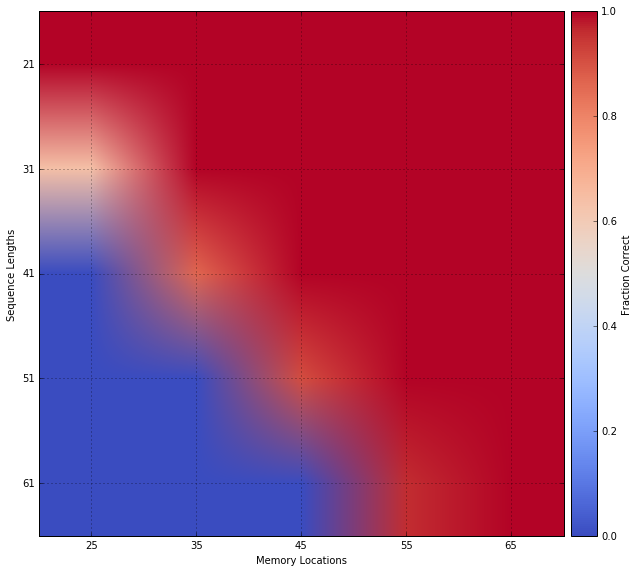

In [116]:
fig, ax = plt.subplots()

imax = ax.imshow(fraction_correct, cmap=plt.cm.coolwarm)

ax.set_ylabel('Sequence Lengths')
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['21', '31', '41', '51', '61'])

ax.set_xlabel('Memory Locations')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['25', '35', '45', '55', '65'])

ax.grid(True)

divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)

fig.colorbar(imax, cax=cbar_ax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], label='Fraction Correct')